# Analysis using identity and normal

The goal of this notebook is to show that using bayesian optimization we are able to find attackers which maximizes leakage.

- If a dataset is constructed using random variables which parameters has to be set in order to maximize the probability of identifing a specific individual in the data


In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd
import opendp.smartnoise.core as sn

# Approach normals - two RV
- An individual who we want to identify in the data
$$X \sim N(\mu_x, \sigma_x^2) $$
- Other individual in the data. Will be noise from the perspective of the attacker.
$$Y \sim N(\mu_y, \sigma_y^2) $$

- Privacy preserving mechanism
$$ Z \leftarrow X+Y $$


The leakage metric

$$ I(X;Z) = H(Z) - H(Z|X) $$
$$ = \dfrac {1}{2} \log(2 \pi e (\sigma_x^2 + \sigma_{y}^2)) - \dfrac{1}{2} \log(2 \pi e (\sigma_{y}^2)) $$
$$ = \dfrac {\log(\sigma_x^2 + \sigma_{y}^2)-\log(\sigma_{y}^2)}{2} $$

Maximum is unbounded.
But since we are bounding our domain such that:

$$\sigma_x, \sigma_{y} \in [10, 1000]$$

The largest leakage is than when:

$$\sigma_x = 10000, \sigma_{y} = 101$$

Resulting in
$$ = \dfrac {\log(1000^2 + 10^2)-\log(10^2)}{2} \approx 4.61 $$

Which is now the goal for our optimizers to reach

In [2]:
def f(x):
    return sum(x)

def analyse_normal(X):
    np.random.seed(12345)
    
    X = X[0]
    
    mus_alice = 0
    std_alice = X[0]
    
    mus_rest = 0
    std_res = X[1]
    
    with pm.Model() as model:
        
        alice = pm.Normal("alice", mus_alice, std_alice, shape=1)
        
        rest = pm.Normal("rest", mus_rest, std_res, shape=1)
        
        db = np.empty(2, dtype=object)
        db[0] = alice[0]
        db[1] = rest[0]
        
        out = pm.Deterministic("out", f(db))
        
        trace = pm.sample(10_000, cores=2)
        
        I = mutual_info_regression(trace["alice"].reshape((-1,1)), trace["out"], discrete_features=False)[0]
        
        return -I
def analytical_solution(std_alice, std_res):
    return -(np.log(std_alice**2+std_res**2)-np.log(std_res**2))/2

### Simulate with the maximum

In [11]:
analyse_normal([[0,1000,0,10]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rest, alice]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 112 seconds.


-4.743053428627356

# Plotting the density of the distribution (using numpy)

In [93]:
def numpy_normal(s1, s2, mu1=0, mu2=0):
    x = np.random.normal(mu1, s1, size=10_000)
    y = np.random.normal(mu2, s2, size=10_000)
    
    out = x+y
    I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False)[0]
        
    return -I

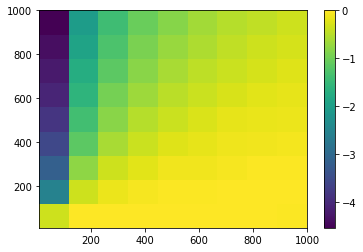

In [35]:
size=10
sigmas = np.linspace(10,1000,size)
Z = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        Z[i][j] = numpy_normal(sigmas[i], sigmas[j])
        print("\r " + str(i), end="\r")
c = plt.pcolormesh(sigmas,sigmas,Z)
plt.colorbar(c)

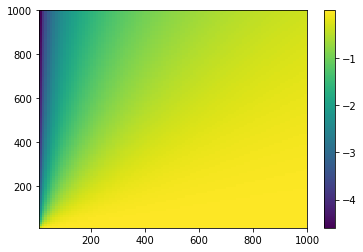

In [28]:
Z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z[i][j] = analytical_solution(s1s[i], s2s[j])
c = plt.pcolormesh(s1s,s2s,Z)
plt.colorbar(c)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 37 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8789932911092999, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8881638025391163, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8874090787838174, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 37 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 36 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


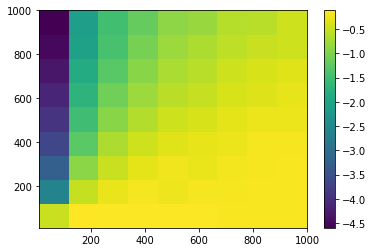

In [38]:
size=10
sigmas = np.linspace(10,1000,size)
Z = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        Z[i][j] = analyse_normal([[sigmas[i], sigmas[j]]])
        print("\r " + str(i), end="\r")
c = plt.pcolormesh(sigmas,sigmas,Z)
plt.colorbar(c)

In [19]:
def numpy_normal2(s1, s2, samples=10_000):
    x = np.random.normal(0, 1000, size=samples)
    y = np.random.normal(s1, s2, size=samples)
    
    out = x+y
    I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False)[0]
        
    return -I

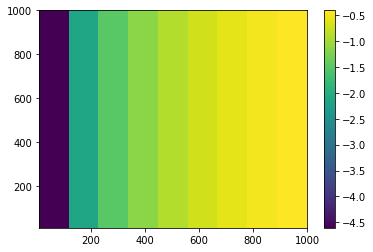

In [53]:
size=10
sigmas = np.linspace(10,1000,size)
Z = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        Z[i][j] = analytical_solution(1000, sigmas[j])
        print("\r " + str(i), end="\r")
c = plt.pcolormesh(sigmas,sigmas,Z)
plt.colorbar(c)

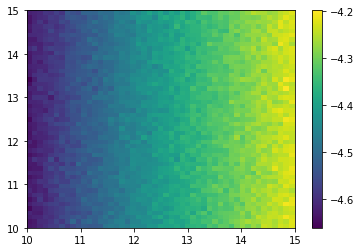

In [58]:
size=50
mus = np.linspace(-1000,1000,size)
sigmas = np.linspace(10,15,size)
Z = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        Z[i][j] = numpy_normal2(mus[i], sigmas[j])
        print("\r " + str(i), end="\r")
c = plt.pcolormesh(sigmas,sigmas,Z)
plt.colorbar(c)

## The problem originates as zoon we add the mean. It is almost impossible for it to find the maximum when the values alter

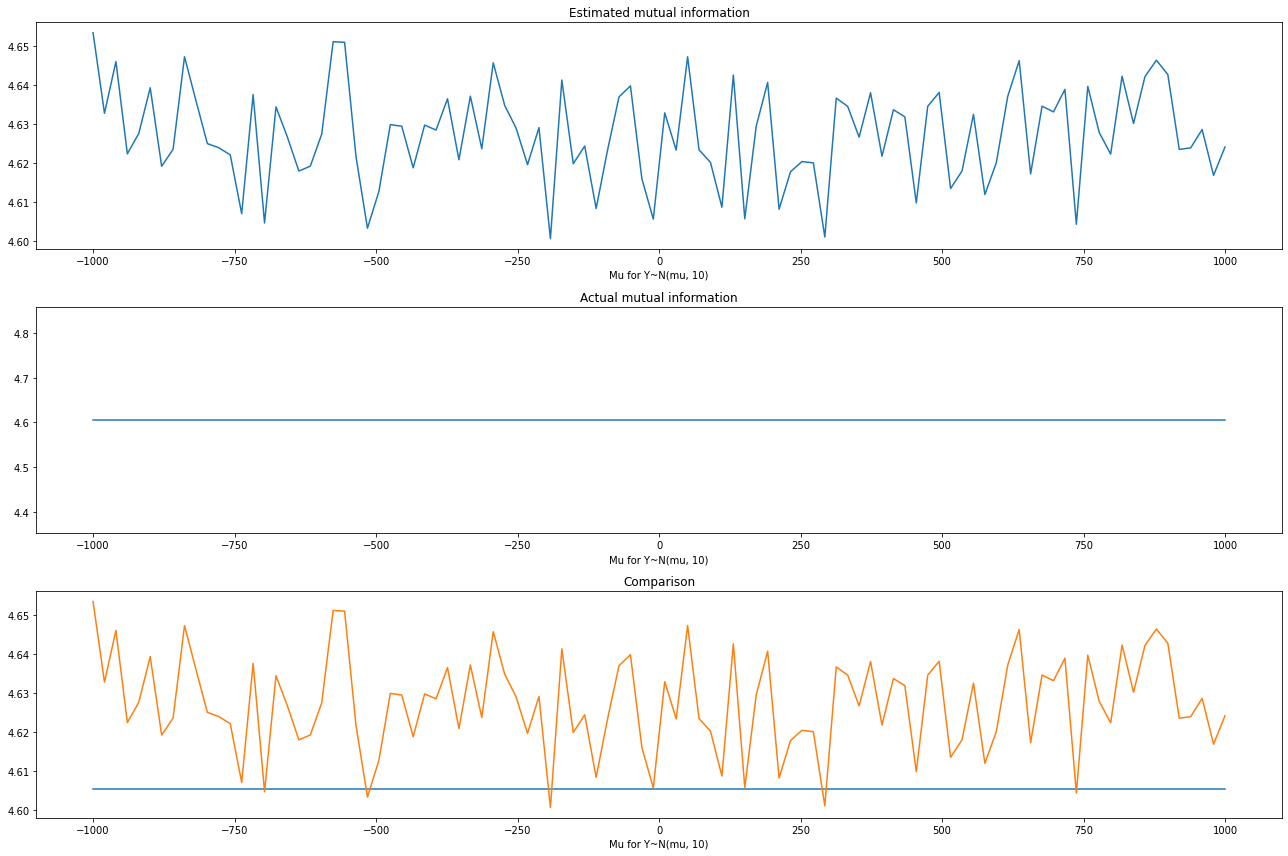

In [17]:
x = np.linspace(-1000,1000,100)
z = [-numpy_normal2(xi, 10) for xi in x]
real_world = [-analytical_solution(1000, 10) for _ in x]
fig, ax = plt.subplots(3,1, figsize=(18,12))
ax[0].plot(x,z)
ax[0].set_title("Estimated mutual information")
ax[0].set_xlabel("Mu for Y~N(mu, 10)")
ax[1].plot(x,real_world)
ax[1].set_title("Actual mutual information")
ax[1].set_xlabel("Mu for Y~N(mu, 10)")
ax[2].plot(x,real_world)
ax[2].plot(x,z)
ax[2].set_title("Comparison")
ax[2].set_xlabel("Mu for Y~N(mu, 10)")
plt.tight_layout()

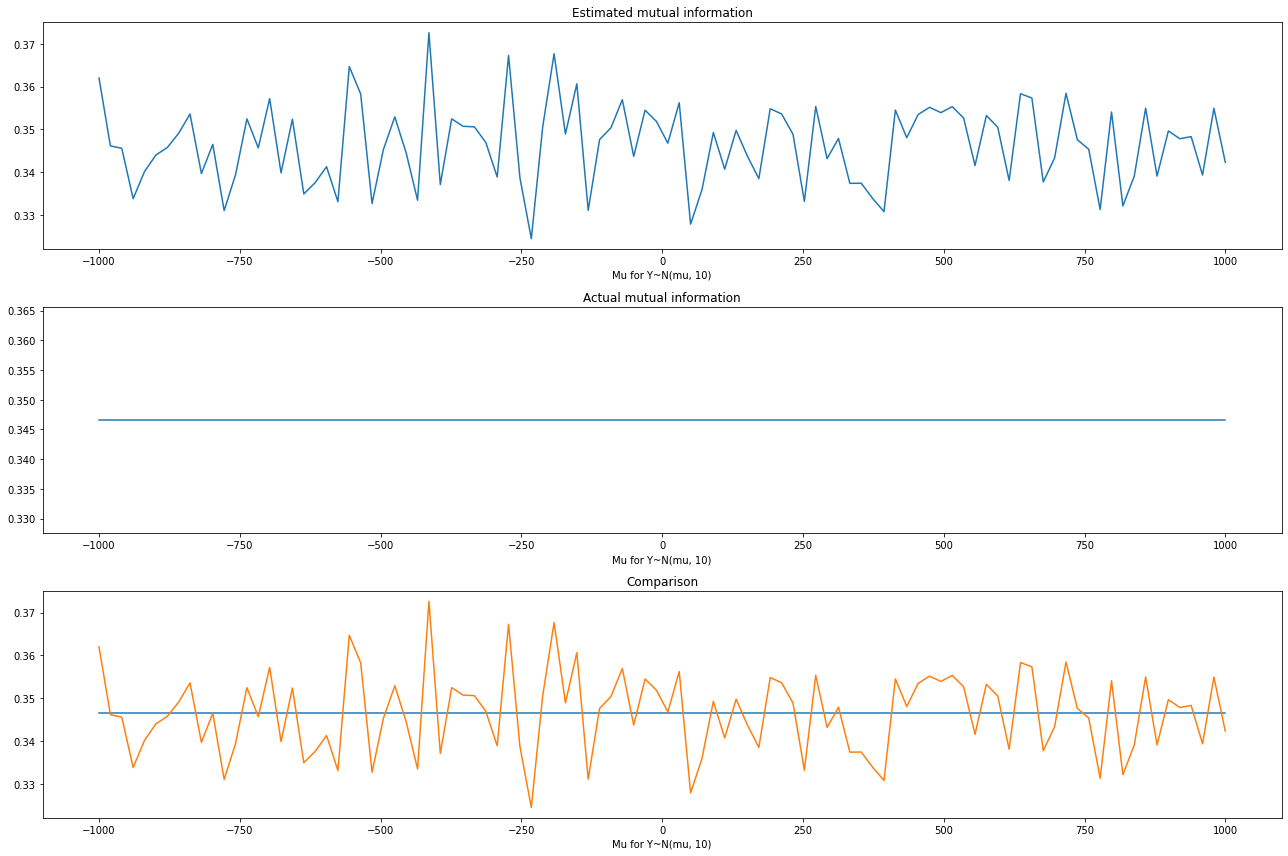

In [51]:
x = np.linspace(-1000,1000,100)
z = [-numpy_normal2(xi, 1000) for xi in x]
real_world = [-analytical_solution(1000, 1000) for _ in x]
fig, ax = plt.subplots(3,1, figsize=(18,12))
ax[0].plot(x,z)
ax[0].set_title("Estimated mutual information")
ax[0].set_xlabel("Mu for Y~N(mu, 10)")
ax[1].plot(x,real_world)
ax[1].set_title("Actual mutual information")
ax[1].set_xlabel("Mu for Y~N(mu, 10)")
ax[2].plot(x,real_world)
ax[2].plot(x,z)
ax[2].set_title("Comparison")
ax[2].set_xlabel("Mu for Y~N(mu, 10)")
plt.tight_layout()

### Using Bayesian optimization

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.8802800309095106, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rest, alice]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.


Value of (x,y) that minimises the objective:[1000.   10.]
Minimum value of the objective: -4.699124888258314


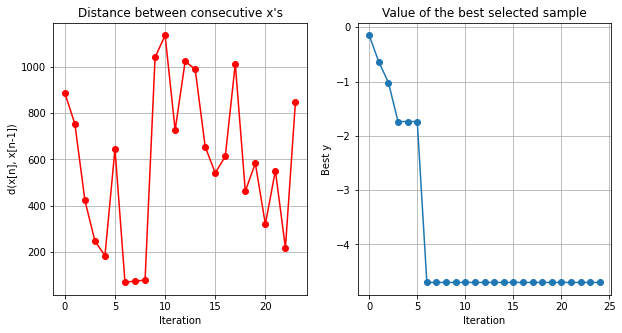

In [41]:
domain = [
    {"name": "alice_std", "type": "continuous", "domain": (10,1000)},
    {"name": "rest_std", "type": "continuous", "domain": (10,1000)}
]
Bopt = BayesianOptimization(f=analyse_normal, domain=domain,
                         acquisition_type='EI')
Bopt.run_optimization(max_iter = 20, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

Value of (x,y) that minimises the objective:[1000.   10.]
Minimum value of the objective: -4.63098790349427


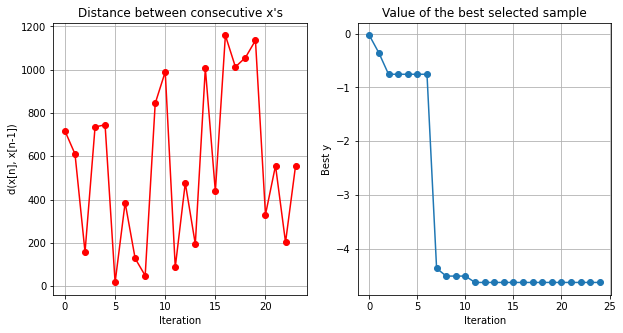

In [54]:
test = lambda x: numpy_normal(x[0][0], x[0][1])

domain = [
    {"name": "alice_std", "type": "continuous", "domain": (10,1000)},
    {"name": "rest_std", "type": "continuous", "domain": (10,1000)}
]
Bopt = BayesianOptimization(f=test, domain=domain,
                         acquisition_type='EI')
Bopt.run_optimization(max_iter = 20, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

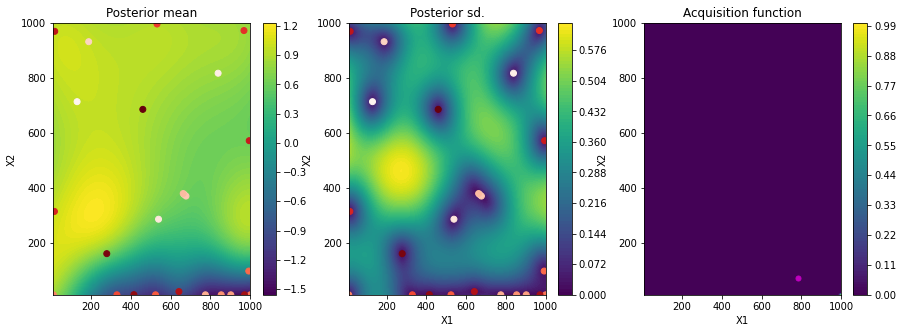

In [56]:
Bopt.plot_acquisition()

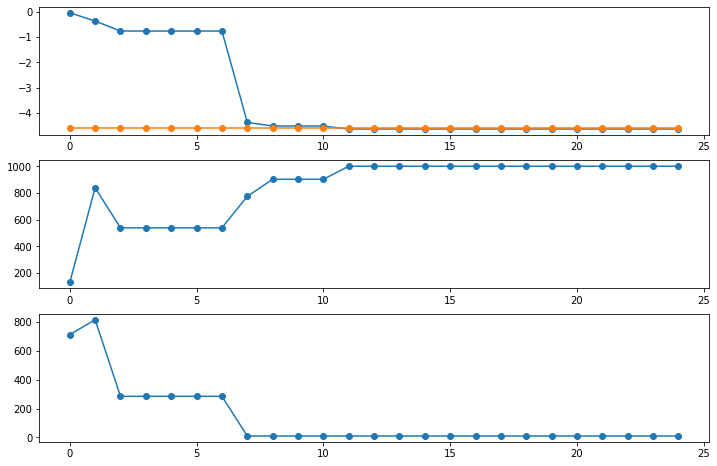

In [87]:
x = np.arange(len(Bopt.Y))
y = [min(Bopt.Y[:i]) for i in range(1,len(x)+1)]
best_x = np.asarray([Bopt.X[np.argmin(Bopt.Y[:i])] for i in range(1,len(x)+1)])
std1 = best_x[:,0]
std2 = best_x[:,1]
best = [analytical_solution(1000,10) for _ in x]
fig, ax = plt.subplots(3,1,figsize=(12,8))
ax[0].plot(x,y, "o-")
ax[0].plot(x,best, "o-")

ax[1].plot(x, std1, "o-")

ax[2].plot(x,std2, "o-")

## Expanding Bayesian optimization to now also encode the mu

Value of (x,y) that minimises the objective:[1000.         1000.         -287.54906524   10.        ]
Minimum value of the objective: -4.613571493426599


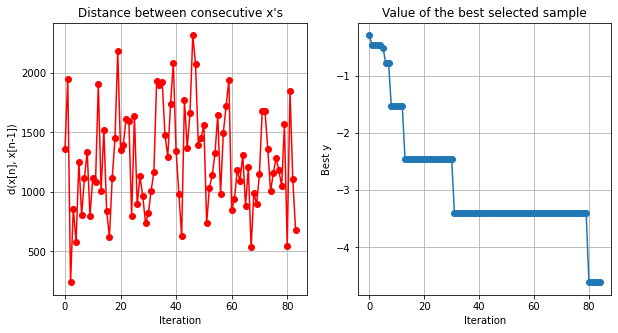

In [90]:
test = lambda x: numpy_normal(x[0][1], x[0][3])
np.random.seed(12345)
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (-1000,1000)},
    {"name": "alice_std", "type": "continuous", "domain": (10,1000)},
    {"name": "rest_mu", "type": "continuous", "domain": (-1000,1000)},
    {"name": "rest_std", "type": "continuous", "domain": (10,1000)}
]
Bopt = BayesianOptimization(f=test, domain=domain,
                         acquisition_type='EI')
Bopt.run_optimization(max_iter = 80, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

#### Here we see that it is slower at reaching the maximum but it does converge

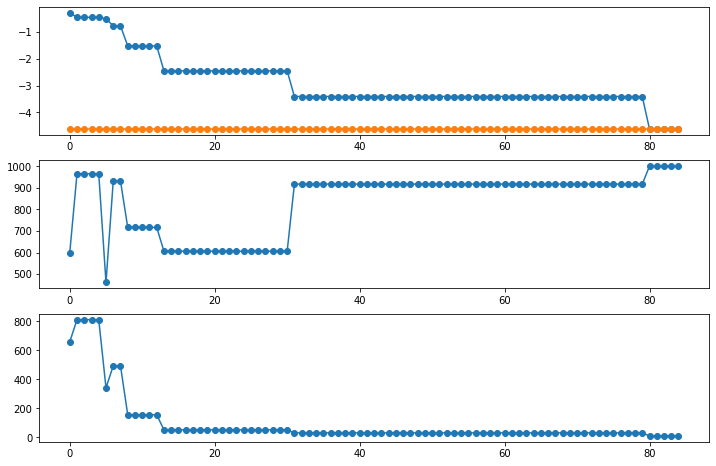

In [92]:
x = np.arange(len(Bopt.Y))
y = [min(Bopt.Y[:i]) for i in range(1,len(x)+1)]
best_x = np.asarray([Bopt.X[np.argmin(Bopt.Y[:i])] for i in range(1,len(x)+1)])
std1 = best_x[:,1]
std2 = best_x[:,3]
best = [analytical_solution(1000,10) for _ in x]
fig, ax = plt.subplots(3,1,figsize=(12,8))
ax[0].plot(x,y, "o-")
ax[0].plot(x,best, "o-")

ax[1].plot(x, std1, "o-")

ax[2].plot(x,std2, "o-")

# PROBLEM
### If we now also include the mean into the generation of the sample, than it will deviate pr. run even if we set the random seed

Value of (x,y) that minimises the objective:[-205.86974391  945.87742616 -447.53239582   16.64459358]
Minimum value of the objective: -4.073330875697412


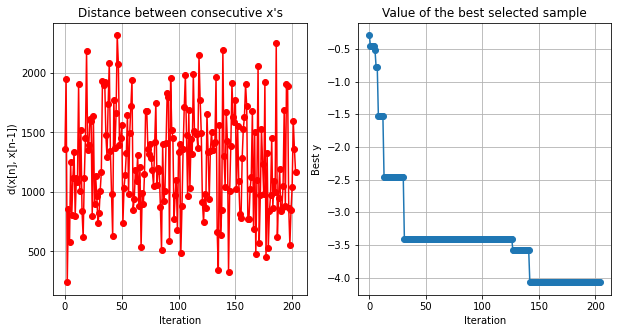

In [95]:
test = lambda x: numpy_normal(x[0][1], x[0][3],x[0][0],x[0][2])
np.random.seed(12345)
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (-1000,1000)},
    {"name": "alice_std", "type": "continuous", "domain": (10,1000)},
    {"name": "rest_mu", "type": "continuous", "domain": (-1000,1000)},
    {"name": "rest_std", "type": "continuous", "domain": (10,1000)}
]
Bopt = BayesianOptimization(f=test, domain=domain,
                         acquisition_type='EI')
Bopt.run_optimization(max_iter = 200, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

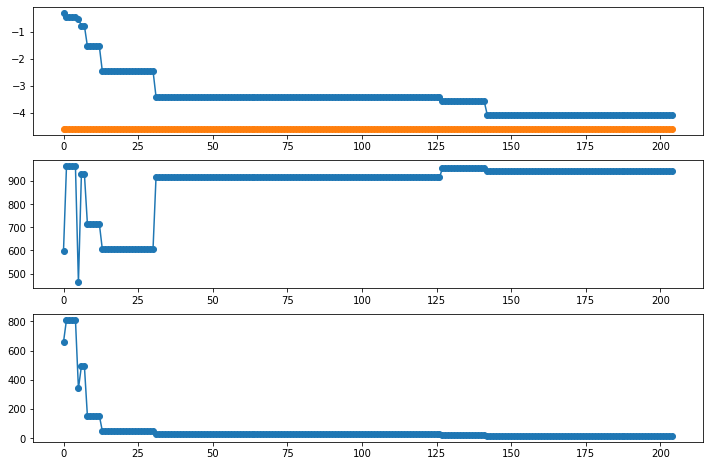

In [96]:
x = np.arange(len(Bopt.Y))
y = [min(Bopt.Y[:i]) for i in range(1,len(x)+1)]
best_x = np.asarray([Bopt.X[np.argmin(Bopt.Y[:i])] for i in range(1,len(x)+1)])
std1 = best_x[:,1]
std2 = best_x[:,3]
best = [analytical_solution(1000,10) for _ in x]
fig, ax = plt.subplots(3,1,figsize=(12,8))
ax[0].plot(x,y, "o-")
ax[0].plot(x,best, "o-")

ax[1].plot(x, std1, "o-")

ax[2].plot(x,std2, "o-")

# Expanding the problem to a database `= 20`

In [123]:
def numpy_normal_db(s1, s2, mu1=0, mu2=0, db_size=20):
    x = np.random.normal(mu1, s1, size=10_000)
    y = np.random.normal(mu2, s2, size=(db_size-1, 10_000))
    
    out = (x+sum(y))
    I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False)[0]
        
    return -I

In [124]:
numpy_normal_db(1000,10)

-3.150814399888672

Value of (x,y) that minimises the objective:[-254.41630605 1000.         1000.           10.        ]
Minimum value of the objective: -3.1708993610749894


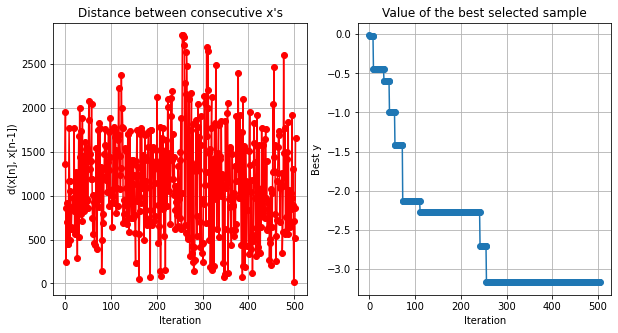

In [126]:
test = lambda x: numpy_normal_db(x[0][1], x[0][3],x[0][0],x[0][2])
np.random.seed(12345)
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (-1000,1000)},
    {"name": "alice_std", "type": "continuous", "domain": (10,1000)},
    {"name": "rest_mu", "type": "continuous", "domain": (-1000,1000)},
    {"name": "rest_std", "type": "continuous", "domain": (10,1000)}
]
Bopt = BayesianOptimization(f=test, domain=domain,
                         acquisition_type='EI')
Bopt.run_optimization(max_iter = 500, eps=1e-3)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

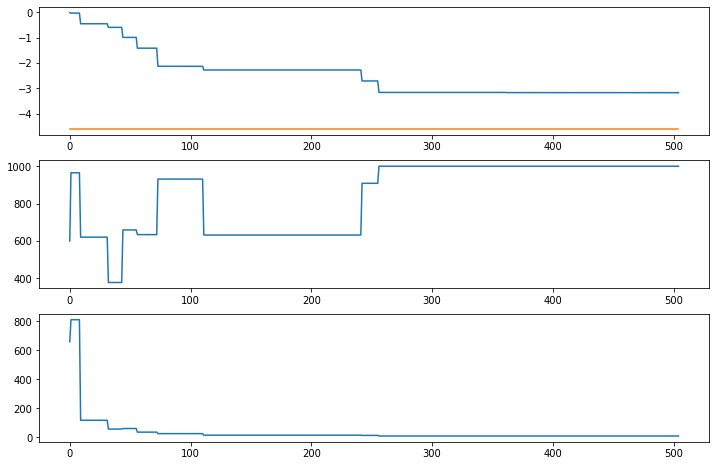

In [128]:
x = np.arange(len(Bopt.Y))
y = [min(Bopt.Y[:i]) for i in range(1,len(x)+1)]
best_x = np.asarray([Bopt.X[np.argmin(Bopt.Y[:i])] for i in range(1,len(x)+1)])
std1 = best_x[:,1]
std2 = best_x[:,3]
best = [analytical_solution(1000,10) for _ in x]
fig, ax = plt.subplots(3,1,figsize=(12,8))
ax[0].plot(x,y, "-")
ax[0].plot(x,best, "-")

ax[1].plot(x, std1, "-")

ax[2].plot(x,std2, "-")

### Expanding to a more complex model, with average age

In [28]:
def f(dataset):
    return sum(dataset)/len(dataset)

def modeling(X, db_size = 20, rng=None):
    if rng == None:
        rng = np.random
    print(X)
    print(X.shape)
    dataset = np.empty(db_size, dtype=object)

    for i in range(db_size):
        dataset[i] = rng.normal(X[i], X[i+db_size], size=10_000)
    
    out = f(dataset)
    
    I = mutual_info_regression(dataset[0].reshape((-1,1)),out, discrete_features=False)[0]
        
    return -I

In [26]:
np.random.seed(12345)
domain = [
    {"name": "mu_", "type": "continuous", "domain": (-1000,1000), "dimensionality": 20},
    {"name": "std_", "type": "continuous", "domain": (10,1000), "dimensionality": 20}
]
Bopt = BayesianOptimization(f=modeling, domain=domain,
                         acquisition_type='EI', initial_design_numdata=40)
Bopt.run_optimization(max_iter = 5000, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

(1, 40)


IndexError: index 20 is out of bounds for axis 0 with size 1

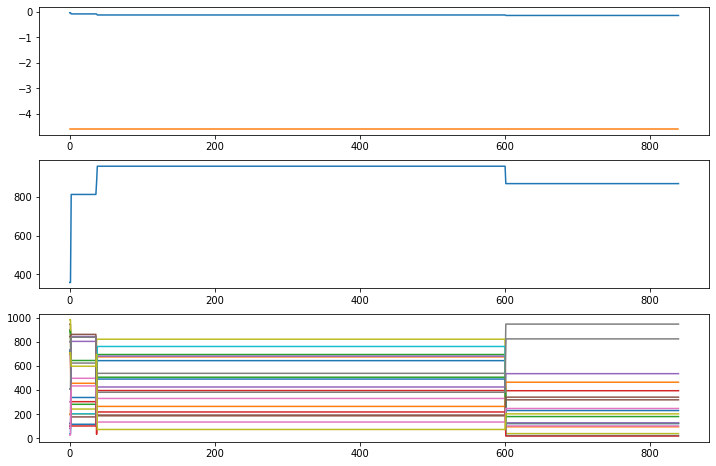

In [162]:
x = np.arange(len(Bopt.Y))
y = [min(Bopt.Y[:i]) for i in range(1,len(x)+1)]
best_x = np.asarray([Bopt.X[np.argmin(Bopt.Y[:i])] for i in range(1,len(x)+1)])
std1 = best_x[:,20]
std2 = best_x[:,3]
best = [analytical_solution(1000,10) for _ in x]
fig, ax = plt.subplots(3,1,figsize=(12,8))
ax[0].plot(x,y, "-")
ax[0].plot(x,best, "-")

ax[1].plot(x, std1, "-")
for i in range(21,40):
    ax[2].plot(x,best_x[:,i], "-")

In [33]:
from scipy import optimize

def normal(X, db_size = 20, rng=None):
    if rng == None:
        rng = np.random

    dataset = np.empty(db_size, dtype=object)

    for i in range(db_size):
        dataset[i] = rng.normal(X[i], X[i+db_size], size=10_000)
    
    out = sum(dataset)/len(dataset)
    
    return -mutual_info_regression(dataset[0].reshape((-1,1)),out, discrete_features=False)[0]


x0 = [10]*20+[0.1]*20
SigmaBounds = (0.1, 15*np.sqrt(3))
muBounds = (10,100)
rng = np.random.RandomState(12345)
f = lambda x: normal(x, db_size=20, rng=rng)
bounds = [muBounds]*20 + [SigmaBounds]*20
print(x0)
optimize.minimize(
    f, 
    x0, 
    method="Powell", 
    bounds=bounds
)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.53214599e+00, -2.40222681e+00, -4.92442660e+00, ...,
        -5.95254100e-03, -6.82696756e-03, -2.37992740e-03]])
     fun: -3.4650490143256887
 message: 'Optimization terminated successfully.'
    nfev: 2061
     nit: 2
  status: 0
 success: True
       x: array([47.90479804, 33.14806579, 45.32092107, 32.58955271, 80.16160171,
       86.7405008


# Approach with normals
The following goal tries to show the maximum leakage using mathematical deduction. Constructing a database of random variables with a fixed size of 4. The random variable that are in question are as follows:
- An individual who we want to identify in the data
$$X \sim N(\mu_x, \sigma_x) $$
- Other individual in the data. Will be noise from the perspective of the attacker.
$$Y = \{Y_0, Y_1, Y_2 \}; S.t. Y_i \sim N(\mu_{y_i}, \sigma_{y_i}) $$

The dataset will than be the union of each element, both X and Y:
$$ Z = X \cup Y$$

The privacy preserving mechanism will be the sum of variables divided by the length.
$$ W = f(Z) = \dfrac{\sum_{i=0}^{4} Z_i}{4}$$

Addition of multiple i.i.d Mormal distribution will result in a Normal distribution where the $\mu$ and $\sigma$ are equal to the sum of its inner Normal distribution. 
Multiplying a scalar. Meaning that the resulting distribution after the privacy preserving mechanism will be the following random variable.

$$ W \sim \dfrac{1}{4} * N(\mu_x + \mu_{y_0} + \mu_{y_1} + \mu_{y_2} + \mu_{y_3}, \sigma_x^2 + \sigma_{y_0}^2 + \sigma_{y_1}^2 + \sigma_{y_2}^2 + \sigma_{y_3}^2) $$

$$ W \sim N(\dfrac{1}{4} * (\mu_x + \mu_{y_0} + \mu_{y_1} + \mu_{y_2} + \mu_{y_3}), \dfrac{1}{4^2} * (\sigma_x + \sigma_{y_0} + \sigma_{y_1} + \sigma_{y_2} + \sigma_{y_3})) $$

Than our metric, will be the entropy between Alice $X$ and the Output $f(Z)$. Resulting in.

$$ I(X;W) = H(W) - H(W|X) $$

Expanding this give us the following equation

$$ I(X;W) = \dfrac {1}{2}* \log(2*\pi*e*\dfrac{1}{4^2} * (\sigma_x^2 + \sigma_{y_0}^2 + \sigma_{y_1}^2 + \sigma_{y_2}^2) - \dfrac{1}{2}*\log(2*\pi*e*\dfrac{1}{4^2} * (\sigma_{y_0}^2 + \sigma_{y_1}^2 + \sigma_{y_2}^2) $$

Using WolframAlpha to try and maximize it, we see that there exist no global maxima. However we can see that if all $\sigma$ of $Y$ are close to 0 than the larger $\sigma_x$ the larger the leakage.

Since we are limiting our domain such that all $-10 000 <= \mu <= 10 000$ and $0.0001 < \sigma_x <=10 000$
The ideal values are the following:

$$Y_i = N(\mu = \text{irrelevant}, \sigma=0.0001)$$
$$X = N(\mu = \text{irrelevant}, \sigma=10000)$$

Remembering that the goal of this exercise is to find the parameters of all distribution such that it maximizes the leakge. Resulting in a mutual information of the following:
    $$\underset{Z}{\operatorname{argmax}} I(X,W) $$

$$= 0.5*log(2*\pi*e*1/4^2 * (10000^2+0.0001^2+0.0001^2+0.0001^2) - 0.5*log(2*\pi*e*1/4^2 * (0.0001^2+0.0001^2+0.0001^2))$$

$$ \approx 9.24 $$